# Bitcoin Price Prediction Using Time Series Analysis and ARIMA

This notebook demonstrates a complete workflow for **predicting Bitcoin prices using time series analysis and the ARIMA family of models**.

We begin by loading minute-level Bitcoin price data from January 1, 2012, resampling and engineering features, and visualising historical trends.  
We then preprocess the data, check for stationarity, and apply Box–Cox transformations and differencing to make the series suitable for ARIMA modelling.  
Autocorrelation analysis guides the choice of SARIMA parameters, after which we train, evaluate, and interpret the model.  
Finally, we generate and visualise future price forecasts, comparing predictions to actual observed values and reporting the model's accuracy.

**Key steps covered:**
- Data cleaning and feature engineering
- Trend and seasonality analysis
- ARIMA/SARIMA model fitting and tuning
- Model diagnostics and residual analysis
- In-sample and out-of-sample prediction
- Forecast visualisation and performance reporting

This notebook is intended as a practical, step-by-step template for any time series forecasting problem in finance or beyond.


In [59]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import warnings
from itertools import product
from datetime import datetime

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## Load and Preview the Bitcoin Price Dataset

We load the minute-level Bitcoin price data directly from the Kaggle datasets directory and preview the first few rows to understand its structure.


In [90]:
df = pd.read_csv(r"btcusd_1-min_data.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


## Convert Timestamps

In [63]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

## Compute Weighted Price

In [64]:
df['Weighted_Price'] = (df['High'] + df['Low'] + df['Close']) / 3


## Calculate VWAP and Resample

In [65]:
tpv = df['Weighted_Price'] * df['Volume']
vwap_day   = tpv.resample('D').sum() / df['Volume'].resample('D').sum()
vwap_month = tpv.resample('M').sum() / df['Volume'].resample('M').sum()
vwap_quarter = tpv.resample('Q-DEC').sum() / df['Volume'].resample('Q-DEC').sum()
vwap_year    = tpv.resample('A-DEC').sum() / df['Volume'].resample('A-DEC').sum()

df_day = vwap_day.to_frame(name='Weighted_Price')
df_month = vwap_month.to_frame(name='Weighted_Price')
df_Q = vwap_quarter.to_frame(name='Weighted_Price')
df_year = vwap_year.to_frame(name='Weighted_Price')

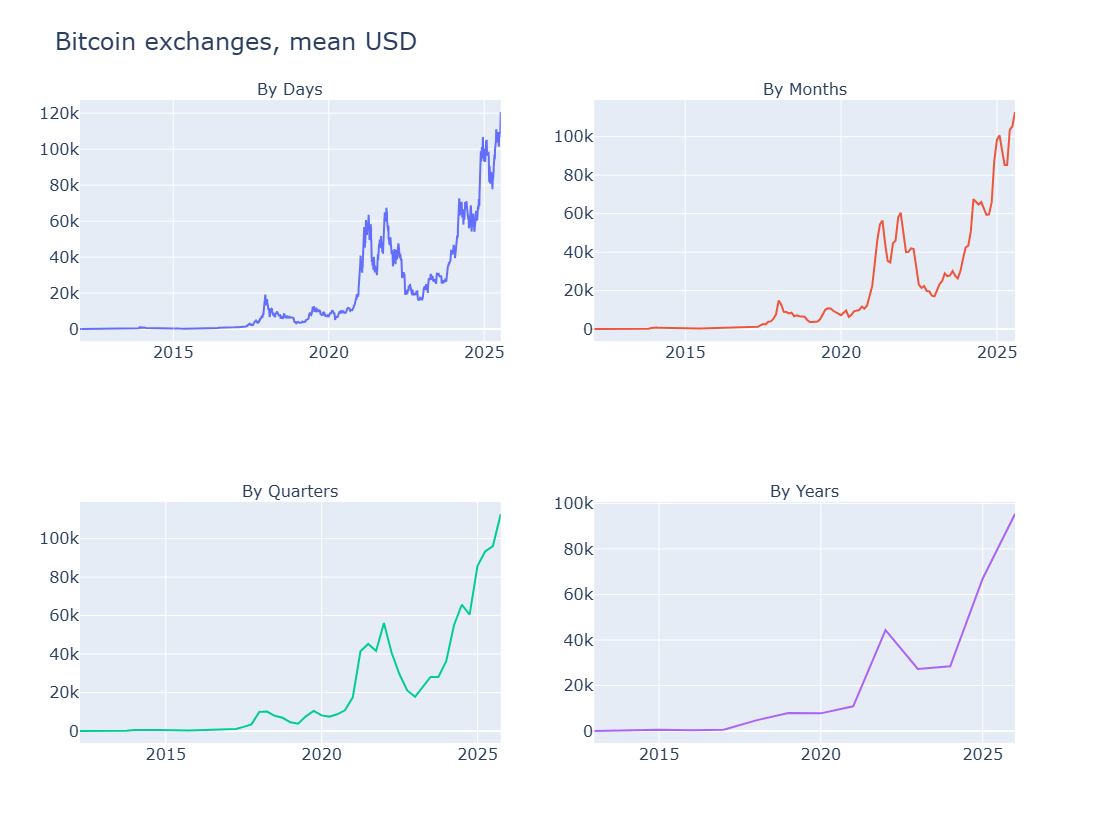

In [66]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['By Days', 'By Months', 'By Quarters', 'By Years']
)

fig.add_trace(
    go.Scatter(x=df_day.index, y=df_day['Weighted_Price'], mode='lines', name='By Days'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df_month.index, y=df_month['Weighted_Price'], mode='lines', name='By Months'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=df_Q.index, y=df_Q['Weighted_Price'], mode='lines', name='By Quarters'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df_year.index, y=df_year['Weighted_Price'], mode='lines', name='By Years'),
    row=2, col=2
)

fig.update_layout(
    height=800, width=1200,
    title_text='Bitcoin exchanges, mean USD',
    showlegend=False,
    font=dict(size=16),
    title_font=dict(size=24)
)

fig.show()


## Seasonal Decomposition

Dickey–Fuller test: p=0.992530


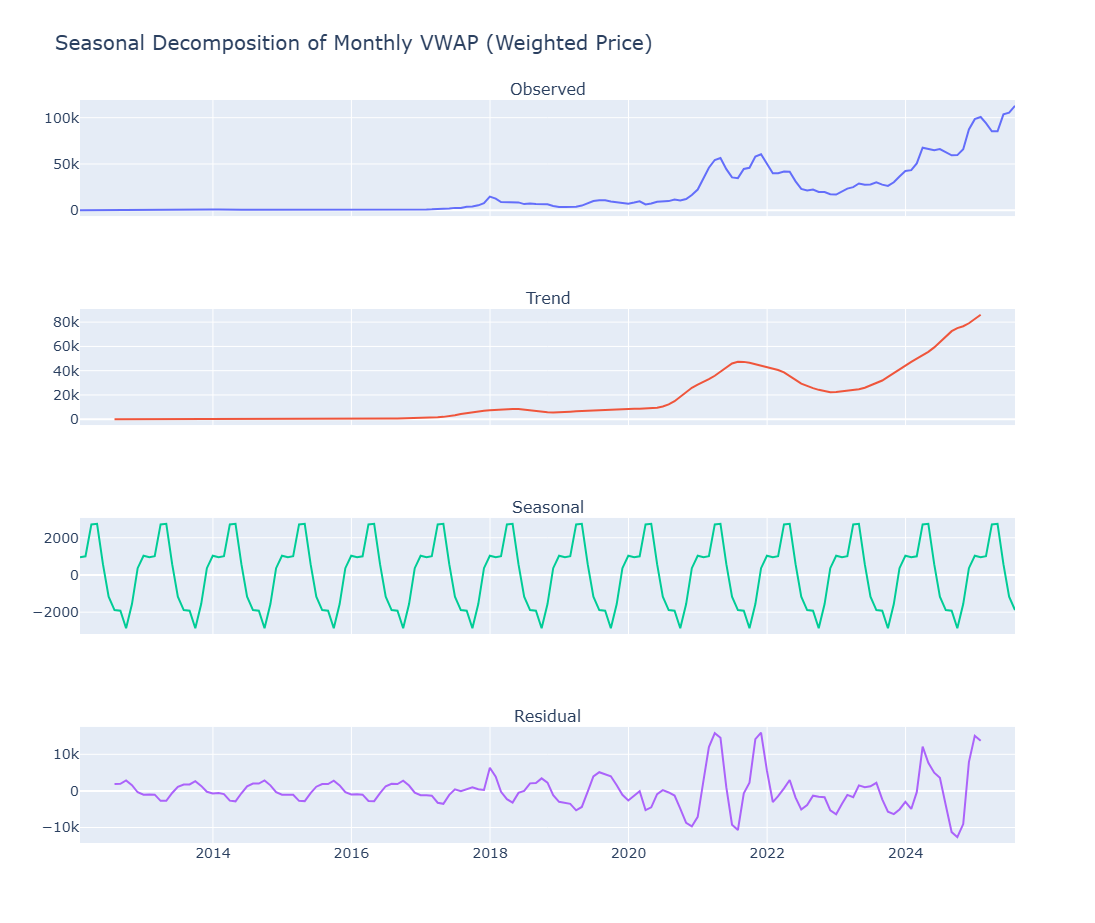

In [73]:
result = sm.tsa.seasonal_decompose(df_month['Weighted_Price'], model='additive', period=12)

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['Weighted_Price'])[1])

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

fig.add_trace(go.Scatter(x=result.observed.index, y=result.observed, name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=result.trend.index,    y=result.trend,    name='Trend'),    row=2, col=1)
fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=result.resid.index,    y=result.resid,    name='Residual'), row=4, col=1)

fig.update_layout(
    height=900, width=1100,
    title_text="Seasonal Decomposition of Monthly VWAP (Weighted Price)",
    showlegend=False,
    font=dict(size=14)
)
fig.show()


## Box-Cox Transformation

In [75]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month['Weighted_Price'])

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['Weighted_Price'])[1])


Dickey–Fuller test: p=0.992530


## First Differencing

In [77]:
df_month['prices_box_diff'] = df_month['Weighted_Price_box'] - df_month['Weighted_Price_box'].shift(1)


## Second Differencing

Dickey–Fuller test: p=0.000000


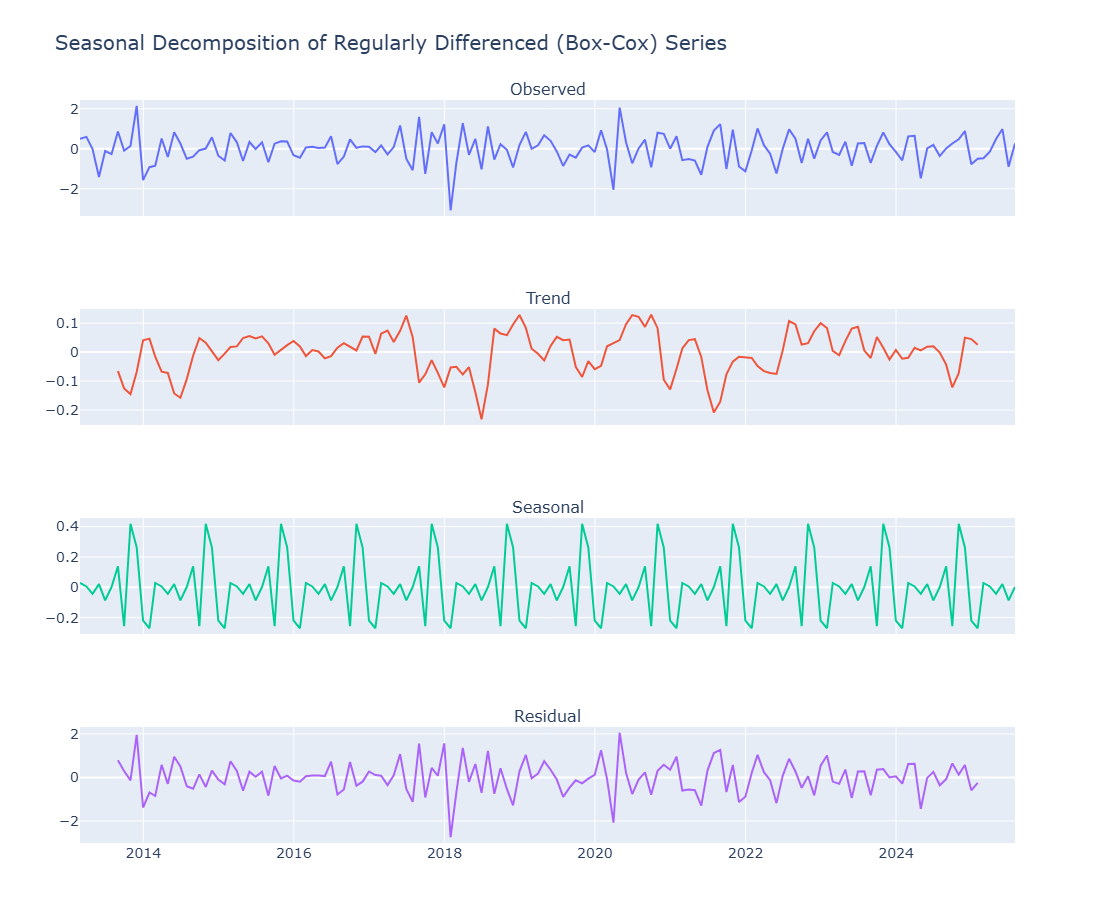

In [79]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)

result = sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:], model='additive', period=12)

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

fig.add_trace(go.Scatter(x=result.observed.index, y=result.observed, name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=result.trend.index,    y=result.trend,    name='Trend'),    row=2, col=1)
fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=result.resid.index,    y=result.resid,    name='Residual'), row=4, col=1)

fig.update_layout(
    height=900, width=1100,
    title_text="Seasonal Decomposition of Regularly Differenced (Box-Cox) Series",
    showlegend=False,
    font=dict(size=14)
)
fig.show()


## Autocorrelation and Partial AutoCorrelation Calculation

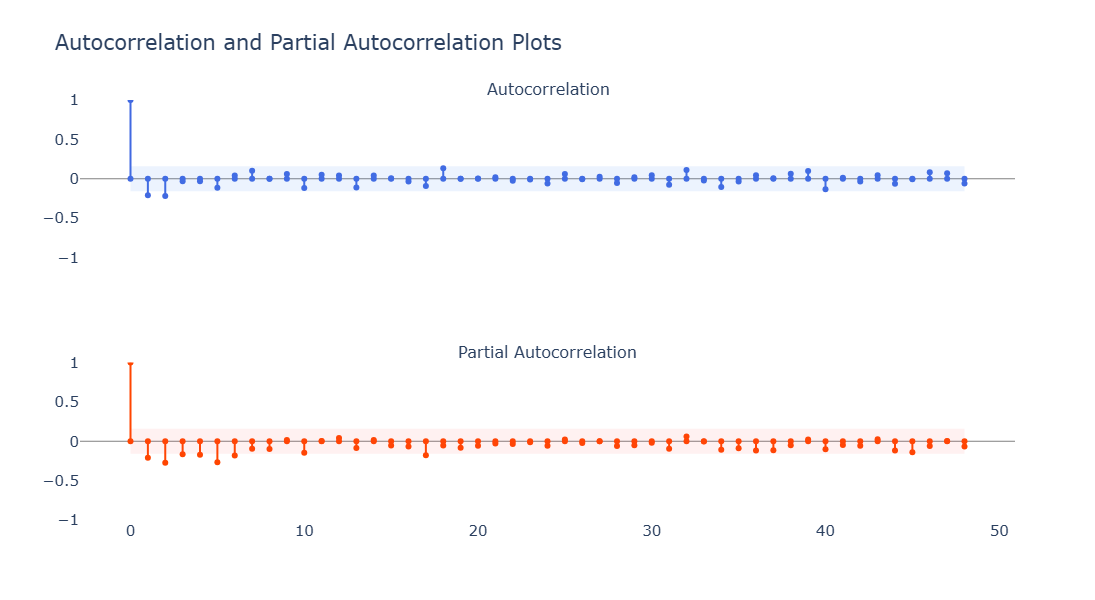

In [81]:
y = df_month['prices_box_diff2'][13:].dropna().values.squeeze()
N = len(y)
lags = np.arange(49)
acf_vals = acf(y, nlags=48)
pacf_vals = pacf(y, nlags=48, method='ywm')

conf_int = 1.96 / np.sqrt(N)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=['Autocorrelation', 'Partial Autocorrelation'])

# ACF: vertical lines + marker (stem plot)
for k in range(len(acf_vals)):
    fig.add_trace(go.Scatter(
        x=[lags[k], lags[k]],
        y=[0, acf_vals[k]],
        mode='lines+markers',
        marker=dict(color='royalblue', size=6),
        line=dict(color='royalblue', width=2),
        showlegend=False
    ), row=1, col=1)

# ACF: confidence band
fig.add_shape(type="rect",
              x0=lags[0], x1=lags[-1],
              y0=-conf_int, y1=conf_int,
              line=dict(color="rgba(0,0,255,0.1)", width=0),
              fillcolor="rgba(66,133,244,0.10)",
              row=1, col=1)

# PACF: vertical lines + marker (stem plot)
for k in range(len(pacf_vals)):
    fig.add_trace(go.Scatter(
        x=[lags[k], lags[k]],
        y=[0, pacf_vals[k]],
        mode='lines+markers',
        marker=dict(color='orangered', size=6),
        line=dict(color='orangered', width=2),
        showlegend=False
    ), row=2, col=1)

# PACF: confidence band
fig.add_shape(type="rect",
              x0=lags[0], x1=lags[-1],
              y0=-conf_int, y1=conf_int,
              line=dict(color="rgba(0,0,255,0.1)", width=0),
              fillcolor="rgba(255,80,80,0.08)",
              row=2, col=1)

fig.update_layout(
    height=600, width=950,
    title_text="Autocorrelation and Partial Autocorrelation Plots",
    font=dict(size=15),
    plot_bgcolor="white"
)

fig.update_yaxes(range=[-1, 1], zeroline=True, zerolinewidth=1, zerolinecolor="gray")

fig.show()


## SARIMA Parameter Grid

In [83]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

## Best Model Results

In [84]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
7   (0, 1, 0, 1)  312.085489
19  (1, 0, 0, 1)  312.728896
37  (2, 0, 0, 1)  312.758932
13  (0, 2, 0, 1)  312.878388
25  (1, 1, 0, 1)  312.887350
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                  163
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -153.043
Date:                            Mon, 14 Jul 2025   AIC                            312.085
Time:                                    11:00:57   BIC                            321.117
Sample:                                01-31-2012   HQIC                           315.755
                                     - 07-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

## Residual Analysis

In [85]:
resid = best_model.resid[13:].dropna()

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(resid)[1])

# Compute ACF for residuals
acf_vals = acf(resid, nlags=48)
lags = np.arange(len(acf_vals))
N = len(resid)
conf_int = 1.96 / np.sqrt(N)

fig = make_subplots(rows=2, cols=1, shared_xaxes=False,
                    subplot_titles=['Model Residuals', 'Autocorrelation of Residuals'])

# Residuals line plot
fig.add_trace(go.Scatter(
    x=resid.index, y=resid,
    mode='lines',
    name='Residuals',
    line=dict(color='mediumblue')
), row=1, col=1)

# ACF stem plot
for k in range(len(acf_vals)):
    fig.add_trace(go.Scatter(
        x=[lags[k], lags[k]],
        y=[0, acf_vals[k]],
        mode='lines+markers',
        marker=dict(color='tomato', size=6),
        line=dict(color='tomato', width=2),
        showlegend=False
    ), row=2, col=1)

# Confidence band for ACF
fig.add_shape(type="rect",
              x0=lags[0], x1=lags[-1],
              y0=-conf_int, y1=conf_int,
              line=dict(color="rgba(0,0,255,0.1)", width=0),
              fillcolor="rgba(66,133,244,0.10)",
              row=2, col=1)

fig.update_layout(
    height=700, width=950,
    title_text="SARIMA Model Residuals and Autocorrelation",
    font=dict(size=15),
    showlegend=False
)
fig.update_yaxes(title_text="Residuals", row=1, col=1)
fig.update_yaxes(range=[-1, 1], zeroline=True, zerolinewidth=1, zerolinecolor="gray", row=2, col=1)
fig.update_xaxes(title_text="Lag", row=2, col=1)
fig.show()


Dickey–Fuller test:: p=0.000000


## Inverse Box-Cox Transformation

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

# Prediction
## Here we predict the price of Bitcoin up till **January 2026**

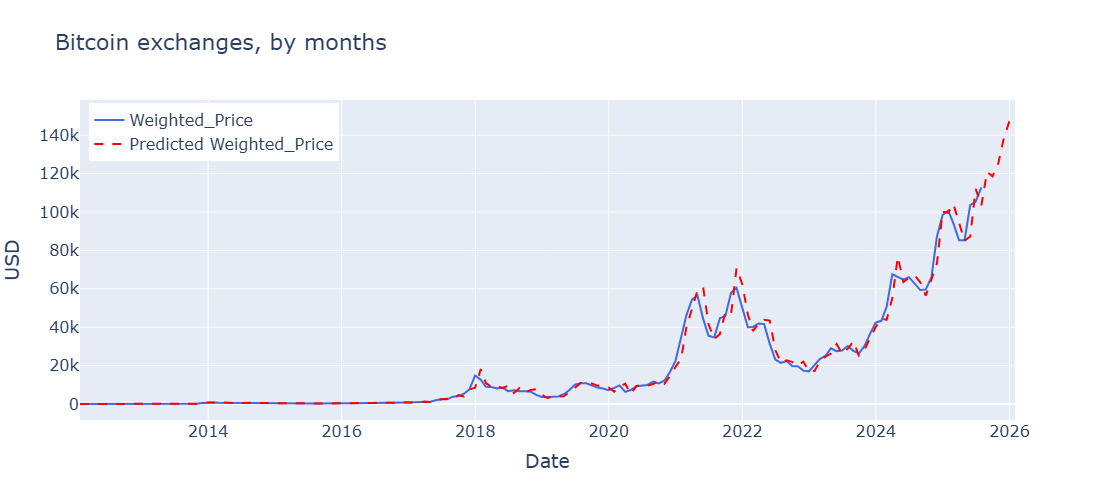

In [113]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y+1)/lmbda)

# 1. Extend the index for full range: history + future
future_dates = pd.date_range(start='2025-07-31', end='2026-01-31', freq='M')
full_index = df_month.index.append(future_dates)

# 2. Predict for entire period (from first to last index)
full_forecast_box = best_model.predict(start=0, end=len(full_index)-1)
full_forecast = invboxcox(full_forecast_box, lmbda)

# 3. Build DataFrame with historical and forecasted
df_plot = pd.DataFrame(index=full_index)
df_plot['Weighted_Price'] = df_month['Weighted_Price']
df_plot['Predicted_Weighted_Price'] = full_forecast

# 4. Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_plot.index, y=df_plot['Weighted_Price'],
    mode='lines', name='Weighted_Price', line=dict(color='royalblue')
))
fig.add_trace(go.Scatter(
    x=df_plot.index, y=df_plot['Predicted_Weighted_Price'],
    mode='lines', name='Predicted Weighted_Price',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    height=500, width=900,
    title='Bitcoin exchanges, by months',
    xaxis_title='Date',
    yaxis_title='USD',
    font=dict(size=16),
    legend=dict(x=0.01, y=0.99)
)
fig.show()

# Accuracy Evaluation

## Yeah we split the data into training and test sets, forecast the test period, and calculate model accuracy as a percentage.

In [ ]:
test_size = 12  # last 12 months for testing

# 1. Split
train = df_month['Weighted_Price'][:-test_size]
test = df_month['Weighted_Price'][-test_size:]

# 2. Box–Cox if used in modeling
train_box = stats.boxcox(train, lmbda=lmbda)

# 3. Fit SARIMA on training data
model = sm.tsa.statespace.SARIMAX(
    train_box,
    order=best_param[:3], 
    seasonal_order=(best_param[2], 1, best_param[3], 12)
).fit(disp=False)

# 4. Forecast test set
forecast_box = model.predict(start=len(train_box), end=len(train_box)+test_size-1)
forecast = invboxcox(forecast_box, lmbda)
forecast = pd.Series(forecast, index=test.index)

# 5. Calculate accuracy (%)
mape = np.mean(np.abs((test - forecast) / test)) * 100
accuracy = 100 - mape

print(f"Model accuracy: {accuracy:.2f}%")
